base_app
- new_scene
- directory
- image_dir
- get_image_dir
- progress
- invalidate
- step
- fieldnames
- get_field
- add_field
- actions
- add_action
- run_action
- traits
- add_trait
- controls
- prepare
- _add_default_fields
- add_custom_property
- add_custom_properties
- _update_scene_properties
- settings_str
- custom_properties
- info
- debug
- scene_summary
- show
- status
- run_step
- play
- pause
- running
- record_frame
- benchmark
- config_recording

App
- prepare
- add_scalar
- editable_float
- editable_int
- editable_values_dict
- get_editable_value
- set_editable_value

LearningApp
- prepare
- set_learning_rate
- set_data
- _init_numpy_iterators
- _init_tf_pipeline
- add_objective
- step
- optimization_step
- on_training_set_end
- validation_step
- base_feed_dict
- _feed_dict
- view_reader
- _view_dataset
- view
- viewed_batch
- view_batch
- save_model
- load_model
- model_scope
- add_field

ControlTraining
- add_all_fields
- load_checkpoints
- action_save_model
- step
- infer_all_frames
- infer_scalars

In [1]:
from phi.tf.session import Session
from phi.data.fluidformat import Scene
from phi.physics.world import World
from phi.physics.domain import Domain
from src.control.pde.incompressible_flow import IncompressibleFluidPDE
from src.control.hierarchy import PDEExecutor
from src.control.sequences import StaggeredSequence
import tensorflow as tf

C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\imeho\Desktop

Could not load resample cuda libraries: CUDA binaries not found at C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\phi\tf\cuda/build/resample.so. Run "python setup.py cuda" to compile them





C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C

In [2]:
batch_size = 16
domain = Domain([64, 64])
dt = 1.0
step_count = 16
obs_loss_frames = [step_count]
trainable_networks = ['CFE', 'OP2', 'OP4', 'OP8', 'OP16']
learning_rate = 5e-4
reg_scale = 1.0

In [3]:
config = tf.ConfigProto()
scene = Scene.create("data", None, count=1, mkdir=True, copy_calling_script=False)
session = Session(scene, session=tf.Session(config=config))
world = World(batch_size=batch_size)
pde = IncompressibleFluidPDE(domain, dt)
pde.create_pde(world, 'CFE' in trainable_networks, True)
world.state = pde.placeholder_state(world, 0)
target_state = pde.placeholder_state(world, step_count * dt)
in_states = [world.state] + [None] * (step_count - 1) + [target_state]

executor = PDEExecutor(world, pde, target_state, trainable_networks, dt)
sequence = StaggeredSequence(step_count, executor)
sequence.execute()

all_states = [frame.worldstate for frame in sequence if frame is not None]



Partition length 16 sequence (from 0 to 16) at frame 8
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Partition length 8 sequence (from 0 to 8) at frame 4
Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6
Partition length 2 sequence (from 4 to 6) at frame 5
Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7
Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12
Partition length 4 sequence (from 8 to 12) at frame 10
Partition length 2 sequence (from 8 to 10) at frame 9
Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11
Execute -> 11
Execute -> 12
Partition 

In [4]:
loss = 0
target_loss = pde.target_matching_loss(target_state, sequence[-1].worldstate)
reg = pde.total_force_loss([state for state in all_states if state is not None])
loss += target_loss
supervised_loss = None
for frame in obs_loss_frames:
    supervised_loss = pde.target_matching_loss(in_states[frame], sequence[frame].worldstate)
    loss += supervised_loss

Instructions for updating:
Use `tf.cast` instead.


In [5]:
all_optimizers = []
optimizer = tf.train.AdamOptimizer(learning_rate)
optim_function = loss + reg
node = optimizer.minimize(optim_function, var_list=None)
all_optimizers.append(node)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
def info(message):
    print(str(message))

In [7]:
session.initialize_variables()

supervised_checkpoints = {'OP%d' % n: 'ckpts/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}
supervised_checkpoints['CFE'] = 'ckpts/CFE/CFE_1000'
executor.load(step_count, supervised_checkpoints, preload_n=True, session=session, logf=info)


Loading CFE from ckpts/CFE/CFE_1000...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ckpts/CFE/CFE_1000\model.ckpt
Loading OP2 from ckpts/supervised/OP2_1000...
INFO:tensorflow:Restoring parameters from ckpts/supervised/OP2_1000\model.ckpt
Loading OP4 from ckpts/supervised/OP4_1000...
INFO:tensorflow:Restoring parameters from ckpts/supervised/OP4_1000\model.ckpt
Loading OP8 from ckpts/supervised/OP8_1000...
INFO:tensorflow:Restoring parameters from ckpts/supervised/OP8_1000\model.ckpt
Loading OP16 from ckpts/supervised/OP16_1000...
INFO:tensorflow:Restoring parameters from ckpts/supervised/OP16_1000\model.ckpt


In [8]:
from phi.tf.flow import struct, isplaceholder, consecutive_frames, Dataset
from phi.data.reader import BatchReader

trace_to_channel = lambda _: 'density'
data_path = 'shape-transitions'
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)


def property_name(trace):
    return trace.name


def collect_placeholders_channels(placeholder_states, trace_to_channel=property_name):
    if trace_to_channel is None:
        trace_to_channel = property_name
    placeholders = []
    channels = []

    for i, state in enumerate(placeholder_states):
        if state is not None:
            traces = struct.flatten(state, trace=True)
            for trace in traces:
                if isplaceholder(trace.value):
                    placeholders.append(trace.value)
                    channel = trace_to_channel(trace)
                    channels.append(consecutive_frames(channel, len(placeholder_states))[i])
    return placeholders, tuple(channels)


placeholders, channels = collect_placeholders_channels(in_states, trace_to_channel=trace_to_channel)
data_load_dict = {p: c for p, c in zip(placeholders, channels)}
train_data = Dataset.load(data_path, train_range)
val_data = Dataset.load(data_path, val_range)

In [9]:
_placeholder_struct = []
_channel_struct = []
for key, value in data_load_dict.items():
    _placeholder_struct.append(key)
    _channel_struct.append(value)
_channel_struct = tuple(_channel_struct)
_placeholder_struct = tuple(_placeholder_struct)
_train_reader = BatchReader(train_data, _channel_struct)
_train_iterator = _train_reader.all_batches(batch_size=batch_size, loop=True)

In [10]:
import tqdm

scalars = []
ph_learning_rate = tf.placeholder(tf.float32, (), "learning_rate")
ph_loss_reg_unscaled = reg
ph_loss_reg_scale = tf.placeholder(tf.float32, (), "loss_reg_scale")
ph_GT_obs_16 = supervised_loss
ph_loss = loss
ph_training = tf.placeholder(tf.bool, (), 'training')

scalars.append(ph_learning_rate)
scalars.append(ph_GT_obs_16)
scalars.append(ph_loss_reg_unscaled)
scalars.append(ph_loss_reg_scale)
scalars.append(ph_loss)

for _ in tqdm.tqdm(range(10)):
    batch = next(_train_iterator)
    optim_nodes = list(all_optimizers)

    feed_dict = {}
    feed_dict[ph_learning_rate] = learning_rate
    feed_dict[ph_loss_reg_scale] = reg_scale
    feed_dict[ph_training] = True
    feed_dict[_placeholder_struct] = batch

    sum_scalars = [
        tf.summary.scalar("learning_rate", ph_learning_rate),
        tf.summary.scalar("GT_obs_16", ph_GT_obs_16),
        tf.summary.scalar("loss_reg_unscaled", ph_loss_reg_unscaled),
        tf.summary.scalar("loss_reg_scale", ph_loss_reg_scale),
        tf.summary.scalar("loss", ph_loss)
    ]
    merged_scalars = tf.summary.merge(sum_scalars)

    scalar_values = session.run(optim_nodes + scalars, feed_dict, summary_key='train', merged_summary=merged_scalars,
                                time=_)[len(optim_nodes):]

    print(scalar_values)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:39<05:54, 39.43s/it]

[array(0.0005, dtype=float32), 48389.195, 354.9742, array(1., dtype=float32), 96778.39]


 20%|██        | 2/10 [01:15<05:01, 37.68s/it]

[array(0.0005, dtype=float32), 24685.557, 219.87668, array(1., dtype=float32), 49371.113]


 30%|███       | 3/10 [01:54<04:25, 37.96s/it]

[array(0.0005, dtype=float32), 57547.156, 470.6967, array(1., dtype=float32), 115094.31]


 40%|████      | 4/10 [02:34<03:53, 38.93s/it]

[array(0.0005, dtype=float32), 40202.3, 337.88153, array(1., dtype=float32), 80404.6]


 50%|█████     | 5/10 [03:16<03:19, 39.95s/it]

[array(0.0005, dtype=float32), 31723.715, 467.82208, array(1., dtype=float32), 63447.43]


 60%|██████    | 6/10 [03:58<02:43, 40.77s/it]

[array(0.0005, dtype=float32), 36502.82, 378.27652, array(1., dtype=float32), 73005.64]


 70%|███████   | 7/10 [04:41<02:04, 41.48s/it]

[array(0.0005, dtype=float32), 23750.816, 473.09528, array(1., dtype=float32), 47501.633]


 80%|████████  | 8/10 [05:27<01:25, 42.74s/it]

[array(0.0005, dtype=float32), 26119.566, 842.8158, array(1., dtype=float32), 52239.133]


 90%|█████████ | 9/10 [06:15<00:44, 44.47s/it]

[array(0.0005, dtype=float32), 38609.906, 810.388, array(1., dtype=float32), 77219.81]


100%|██████████| 10/10 [07:04<00:00, 42.47s/it]

[array(0.0005, dtype=float32), 38887.117, 1065.9049, array(1., dtype=float32), 77774.234]


In [13]:
def infer_all_frames(data_range):
    dataset = Dataset.load(data_path, data_range)
    reader = BatchReader(dataset, _channel_struct)
    batch = reader[0:len(reader)]

    feed_dict = {}
    feed_dict[ph_learning_rate] = learning_rate
    feed_dict[ph_loss_reg_scale] = reg_scale
    feed_dict[ph_training] = True
    feed_dict[_placeholder_struct] = batch

    inferred = session.run(all_states, feed_dict=feed_dict)
    return inferred

In [14]:
states = infer_all_frames(test_range)

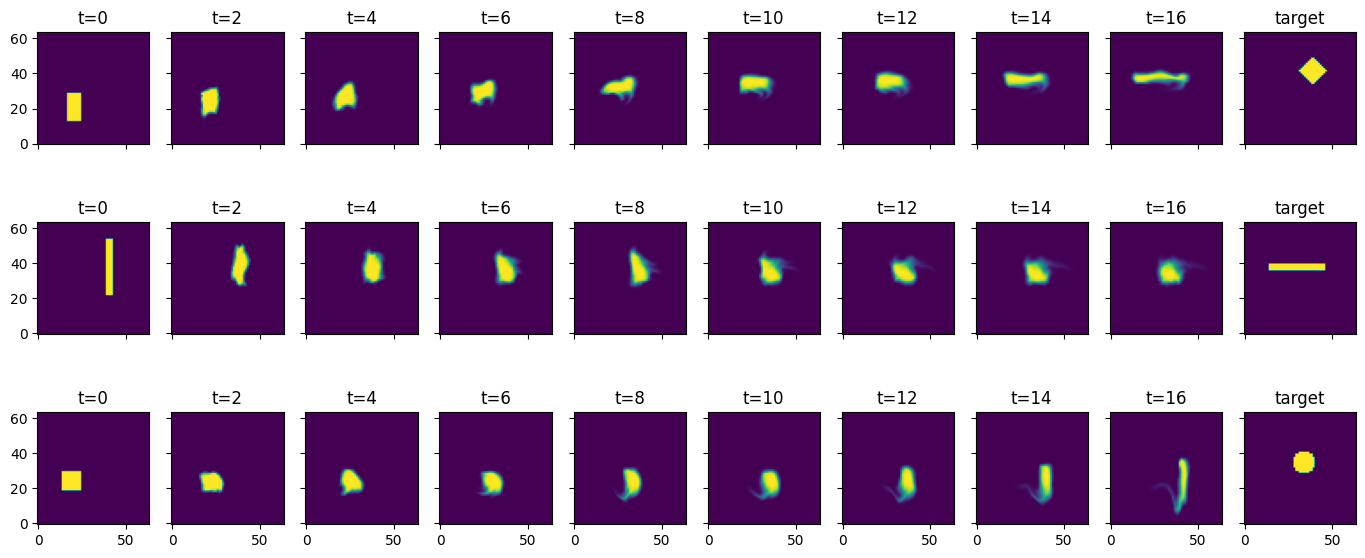

In [16]:
import pylab

batches = [1,2,3]

pylab.subplots(len(batches), 10, sharey='row', sharex='col', figsize=(14, 6))
pylab.tight_layout(w_pad=0)

# solutions
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 10, t + 1 + i * 10)
        pylab.title('t=%d' % (t * 2))
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')

# add targets
testset = BatchReader(Dataset.load(data_path, test_range), _channel_struct)[test_range]
for i, batch in enumerate(batches):
    pylab.subplot(len(batches), 10, i * 10 + 10)
    pylab.title('target')
    pylab.imshow(testset[1][i, ..., 0], origin='lower')


In [ ]:
# import matplotlib.pyplot as plt
#
# # 假设 batch = (images_start, images_end)
# images_start, images_end = batch  # 两个形状均为 (16, 64, 64, 1)
#
# fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(4, 32))  # 16 行, 2 列
#
# for i in range(16):
#     # 第一列：起始图片
#     axes[i, 0].imshow(images_start[i, :, :, 0], cmap='gray')
#     axes[i, 0].axis('off')
#
#     # 第二列：结束图片
#     axes[i, 1].imshow(images_end[i, :, :, 0], cmap='gray')
#     axes[i, 1].axis('off')
#
# plt.tight_layout()
# plt.show()